We'll implement the SELayer, which tries to extract global features. Explained in the link below:

https://amaarora.github.io/fastexplain/2020/07/24/SeNet.html



    We expect the learning of convolutional features to be enhanced by explicitly modelling channel interdependencies, so that the network is able to increase its sensitivity to informative features which can be exploited by subsequent transformations. Consequently, we would like to provide it with access to global information and recalibrate filter responses in two steps, squeeze and excitation, before they are fed into the next transformation.

 ![CleanShot 2024-10-18 at 09.11.38@2x.png](<attachment:CleanShot 2024-10-18 at 09.11.38@2x.png>)
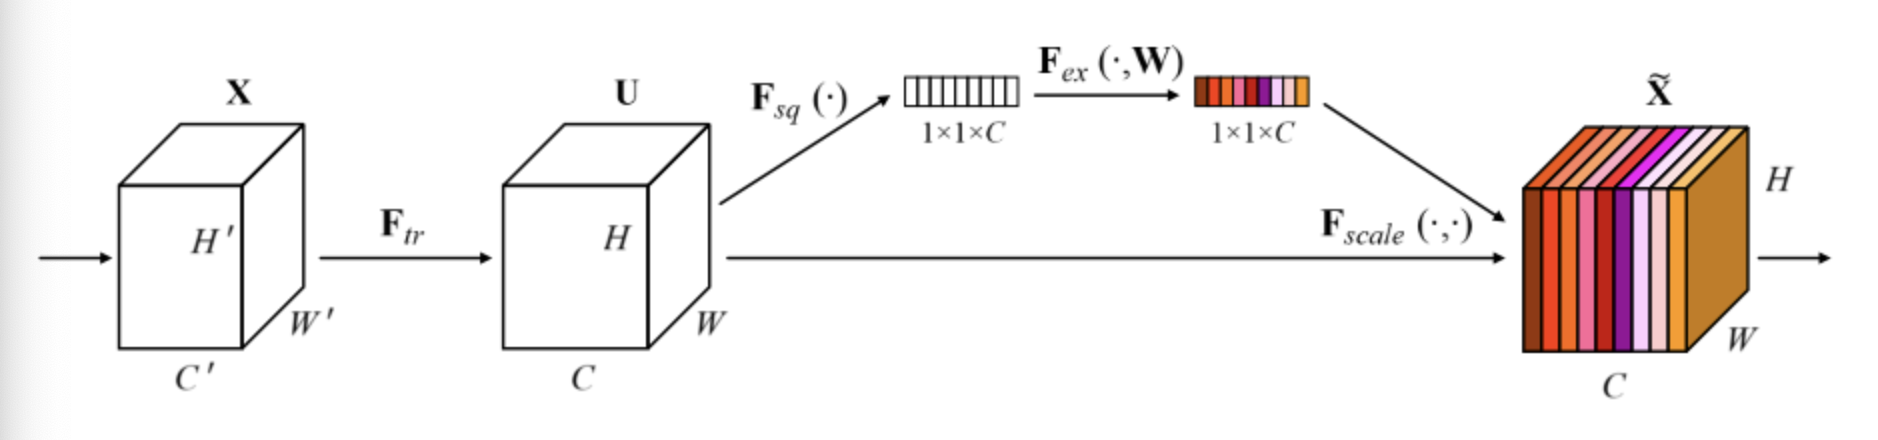

We're also using eqx.Module. All this seems to do is register the class as a PyTree for JAX to work with. PyTrees are JAX's idea to manage complex composed data

First take the global average.

$$z_c = \mathbf{F}_{sq}(\mathbf{u}_c) = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} u_c(i,j)$$

Then apply FFN, ReLU, FFN and Sigmoid. Unsure why you would need both though ?

$$\mathbf{s} = \mathbf{F}_{ex}(\mathbf{z}, \mathbf{W}) = \sigma(g(\mathbf{z}, \mathbf{W})) = \sigma(\mathbf{W}_2 \delta(\mathbf{W}_1 \mathbf{z}))$$

The two FFN form bottleneck architecture.

Finally, we multiply $$\mathbf{s}\mathbf{u_c}$$ to get the weighted channels.

Why this excitation function ? To use the information of the sqeeze, follow it by capturing channel-wise dependencies. To do this excitation needs to: Be flexible, and learn non-mutually-exclusive relationships to make sure mutliple channels are emphasised.

The role of the first **W_1** is to reduce the dimensionality.

__This__ is why the activation is sigmoid, which allows multiple channels to have high importance compared to softmax which would impose importance on just one.

### Things to play around with:

- [ ] Do we really need to reduce to one global average directly ?
- [ ] Why use ReLU ? Maybe other solutions ?
- [ ] What's the difference between AdaptiveAvgPool2d and AvgPool2d ? 
- [ ] Why not use 3d convolutions to understand dependencies between channels ? What about a conformer ?


In [5]:
import equinox as eqx
import jax


class SELayer(eqx.Module):
    fc1: eqx.nn.Linear
    fc2: eqx.nn.Linear

    def __init__(self, channel, key, reduction=8):
        key1, key2 = jax.random.split(key, 2)
        self.fc1 = eqx.nn.Linear(channel, channel // reduction, use_bias=True, key=key1)
        self.fc2 = eqx.nn.Linear(channel // reduction, channel, use_bias=True, key=key2)

    def __call__(self, x):
        y = eqx.nn.AdaptiveAvgPool2d(1)(x)
        y = jax.numpy.squeeze(y)
        y = self.fc1(y)
        y = jax.nn.relu(y)
        y = self.fc2(y)
        y = jax.nn.sigmoid(y)
        y = jax.numpy.expand_dims(y, (1, 2))
        
        return x * y

We can test out the above block by feeding random values in a batch like manner. We use vmap function of JAX to accelerate the process.

In [6]:

@jax.grad
# @jax.jit
def loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2) # L2 Loss

# loss = jax.grad(loss)

x_key, y_key, model_key = jax.random.split(jax.random.PRNGKey(0), 3)
# Example data
x = jax.random.normal(x_key, (100, 100, 256, 256)).astype(jax.numpy.float32)
y = jax.random.normal(y_key, (100, 100)).astype(jax.numpy.float32)

model = SELayer(100, model_key, reduction=2)
# Compute gradients
grads = loss(model, x, y)
# Perform gradient descent
learning_rate = 0.1
new_model = jax.tree_util.tree_map(lambda m, g: m - learning_rate * g, model, grads)

<class 'jax._src.interpreters.batching.BatchTracer'>
<class 'jax._src.interpreters.batching.BatchTracer'>
(100, 256, 256)
(100, 1, 1)


ValueError: Incompatible shapes for broadcasting: shapes=[(100, 100), (100, 100, 256, 256)]

### Comparing to PyTorch

We can also write the funcion in PyTorch and compare.

In [65]:
import torch
import torch.nn as nn
import numpy as np

# Define PyTorch version of SELayer
class SELayerTorch(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SELayerTorch, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [68]:
torch_model = SELayerTorch(32, reduction=8)
torch_model.eval()

# Initialize JAX model with same parameters
key = jax.random.PRNGKey(0)
jax_model = SELayerJax(32, key=key, reduction=8)

# Example input for JAX model
input_tensor_jax = jax.random.normal(key, (1, 32, 64, 64))
output_jax = jax.vmap(jax_model)(input_tensor_jax)

# Example input for PyTorch model
print(type(input_tensor_jax))
input_tensor_torch = torch.tensor(np.array(input_tensor_jax))
print(input_tensor_torch.size())
output_torch = torch_model(input_tensor_torch).detach().numpy()


# Copy weights and biases from JAX model to PyTorch model
with torch.no_grad():
    torch_model.fc[0].weight.copy_(torch.tensor(np.array(jax_model.fc1.weight)))
    torch_model.fc[0].bias.copy_(torch.tensor(np.array(jax_model.fc1.bias)))
    torch_model.fc[2].weight.copy_(torch.tensor(np.array(jax_model.fc2.weight)))
    torch_model.fc[2].bias.copy_(torch.tensor(np.array(jax_model.fc2.bias)))

# Convert JAX output to numpy
output_jax_np = np.array(output_jax)

# Compare outputs
print(np.allclose(output_torch, output_jax_np, atol=1e-5))  # Should return True if they match closely

# Compute absolute differences
differences = np.abs(output_torch - output_jax_np)

# Find where the differences exceed the tolerance
diff_exceeds_tolerance = differences > 1e-5

# Print the indices and values of the elements that are different
print("Indices where the outputs differ:")
print(np.argwhere(diff_exceeds_tolerance))


print("\nDifferences at those points:")
print(differences[diff_exceeds_tolerance])

(32,)
<class 'jaxlib.xla_extension.ArrayImpl'>
torch.Size([1, 32, 64, 64])
False
Indices where the outputs differ:
[[ 0  0  0  0  0]
 [ 0  0  0  0  1]
 [ 0  0  0  0  2]
 ...
 [ 0  0 31 63 61]
 [ 0  0 31 63 62]
 [ 0  0 31 63 63]]

Differences at those points:
[0.03054592 0.01835971 0.00503328 ... 0.18904695 0.09917451 0.20863083]
